In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change directory to the desired location in Google Drive
import os
os.chdir('/content/gdrive/MyDrive')

Mounted at /content/gdrive


0    6102
1     290
Name: right_cataract, dtype: int64
['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
594 600


100%|██████████| 594/594 [03:35<00:00,  2.76it/s] 


588


100%|██████████| 600/600 [05:46<00:00,  1.73it/s]


1188


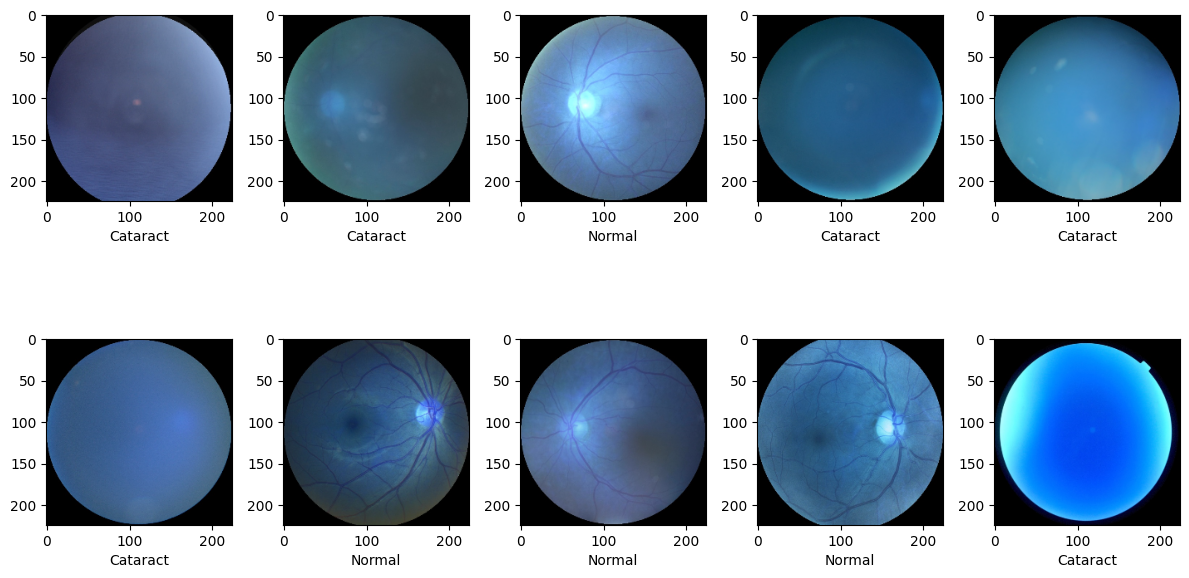

In [3]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Print the first few filenames
print(right_normal[:15])

# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

# Define the dataset directory and image size
dataset_dir = "/content/gdrive/MyDrive/Computer_vision_project/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(label)])
    
    random.shuffle(dataset)
    return dataset

# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [4]:
# With Hyperparameters Tuning  VGG 19

In [5]:
import time 


In [6]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 4s 0us/step


In [7]:
  for layer in vgg.layers:
    layer.trainable = False

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [10]:
# Start the timer
start_time = time.time()

Epoch 1/5
30/30 [==============================] - ETA: 0s - loss: 0.9771 - accuracy: 0.9084 

30/30 [==============================] - 923s 31s/step - loss: 0.9771 - accuracy: 0.9084 - val_loss: 1.3046 - val_accuracy: 0.9286
Epoch 2/5
30/30 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9768 

30/30 [==============================] - 917s 31s/step - loss: 0.1787 - accuracy: 0.9768 - val_loss: 1.3404 - val_accuracy: 0.9412
Epoch 3/5
30/30 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9895 

30/30 [==============================] - 916s 31s/step - loss: 0.0479 - accuracy: 0.9895 - val_loss: 1.1536 - val_accuracy: 0.9328
Epoch 4/5
30/30 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9989 

30/30 [==============================] - 894s 30s/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 1.1214 - val_accuracy: 0.9328
Epoch 5/5
30/30 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9926 

8/8 [==============================] - 179s 22s/step - loss: 1.4225 - accuracy: 0.9496
loss: 1.4225013256072998
Accuracy: 0.9495798349380493
8/8 [==============================] - 179s 22s/step - loss: 1.4225 - accuracy: 0.9496
Test Loss: 1.4225013256072998
Test Accuracy: 0.9495798349380493


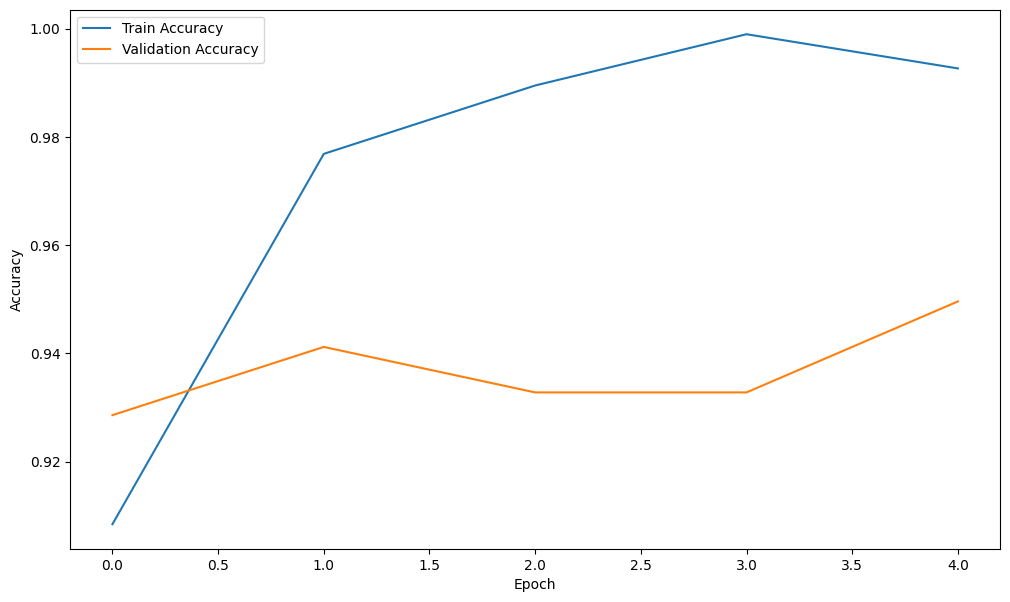

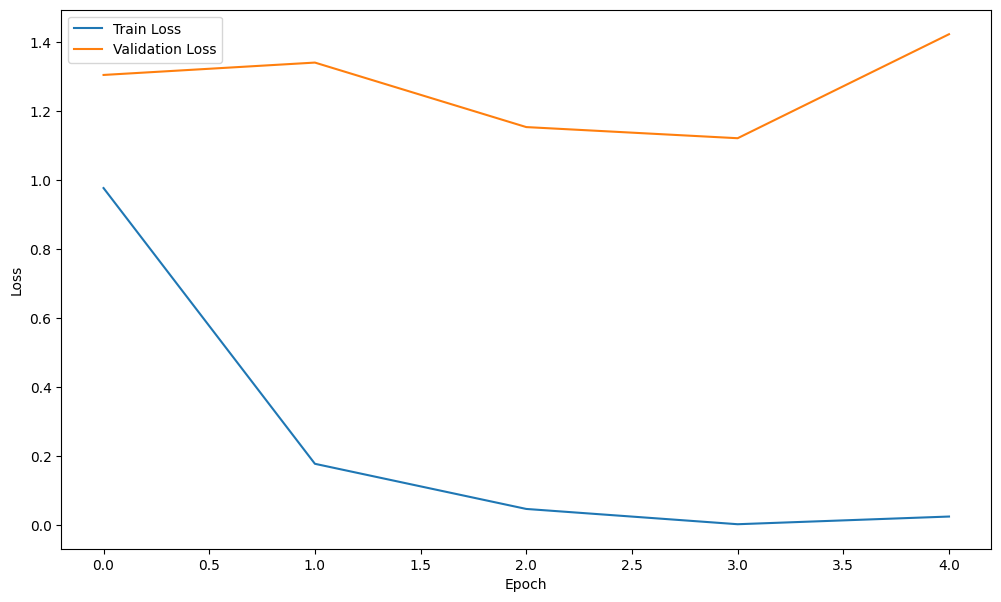

8/8 [==============================] - 178s 22s/step


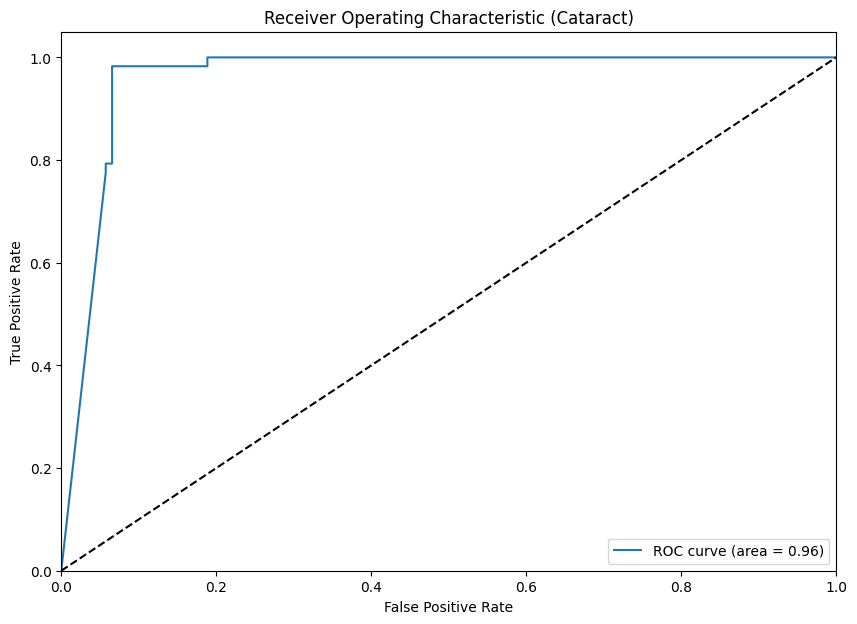

              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95       122
    Cataract       0.92      0.98      0.95       116

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238

8/8 [==============================] - 179s 22s/step - loss: 1.4225 - accuracy: 0.9496
Test Loss: 1.4225013256072998
Test Accuracy: 0.9495798349380493


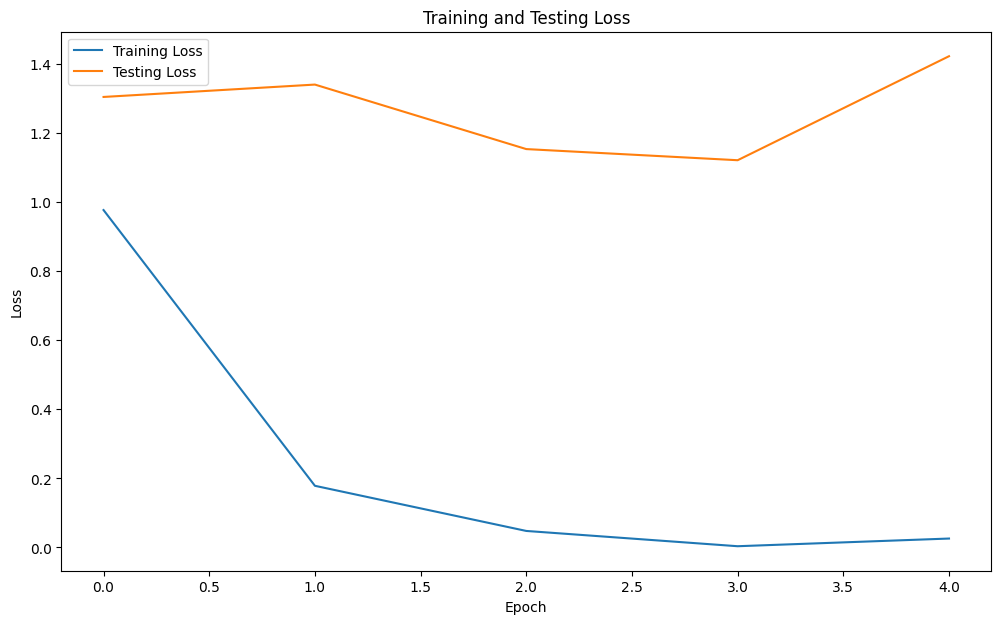

Training Time: 5368.974123954773 seconds


In [11]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')


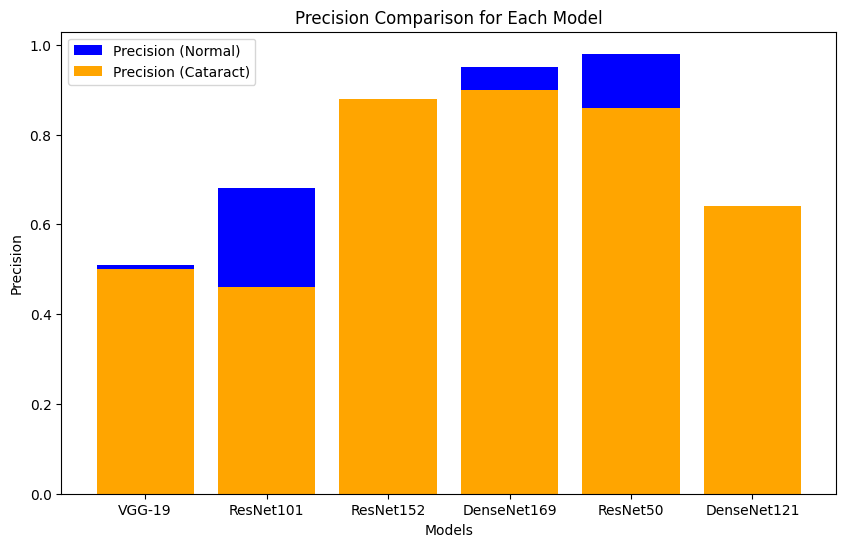

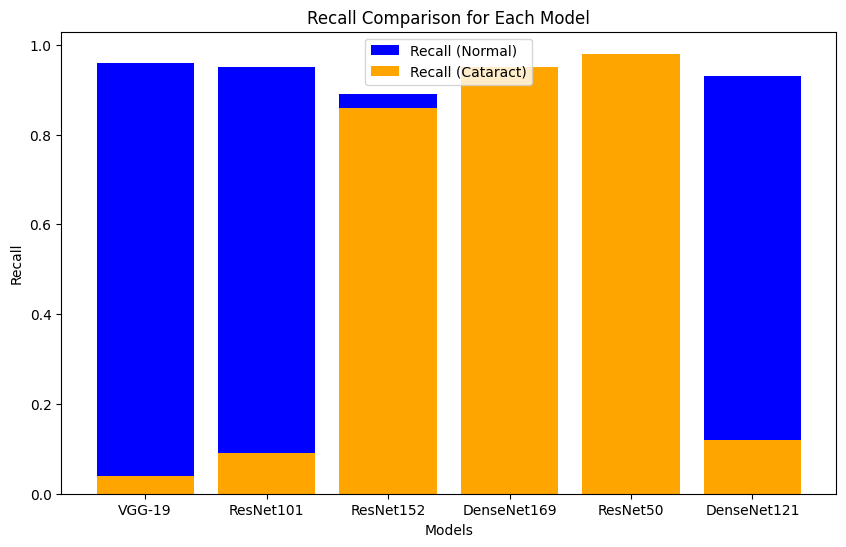

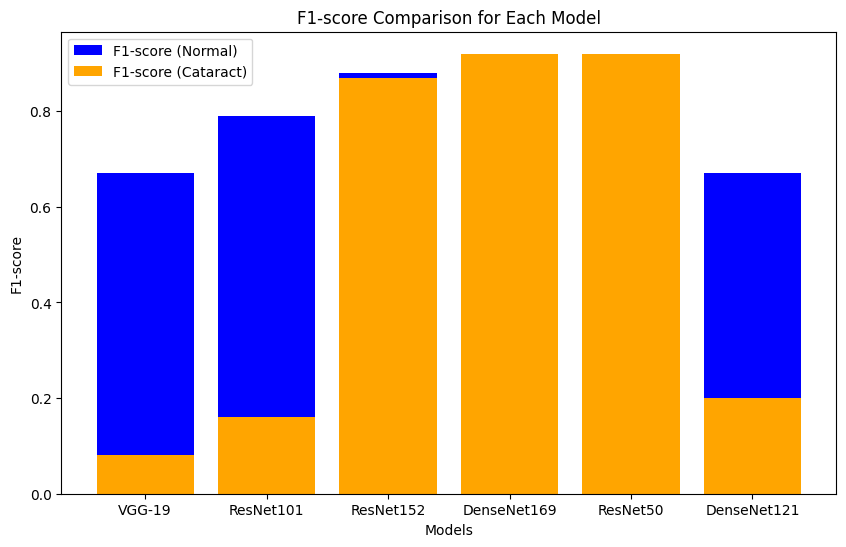

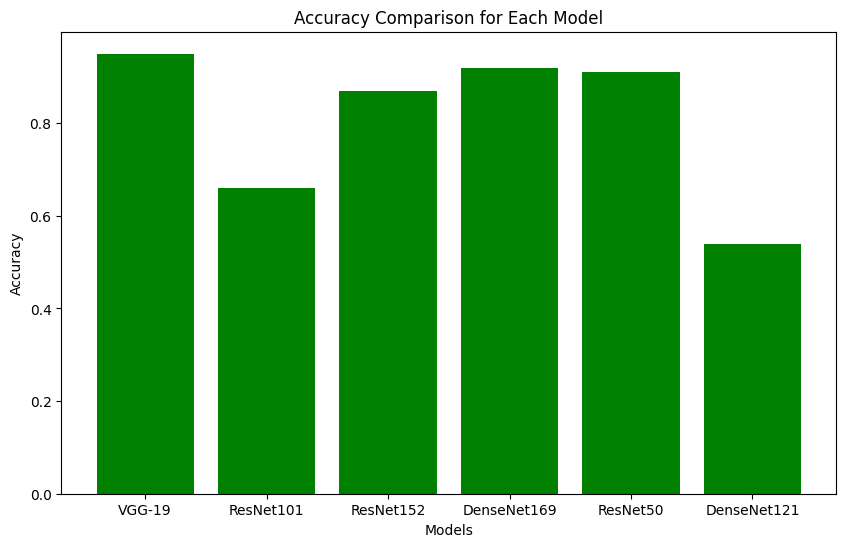

In [13]:
import matplotlib.pyplot as plt

models = ['VGG-19', 'ResNet101', 'ResNet152', 'DenseNet169', 'ResNet50', 'DenseNet121']
precision_normal = [0.51, 0.68, 0.87, 0.95, 0.98, 0.53]
precision_cataract = [0.50, 0.46, 0.88, 0.90, 0.86, 0.64]
recall_normal = [0.96, 0.95, 0.89, 0.90, 0.84, 0.93]
recall_cataract = [0.04, 0.09, 0.86, 0.95, 0.98, 0.12]
f1_score_normal = [0.67, 0.79, 0.88, 0.92, 0.91, 0.67]
f1_score_cataract = [0.08, 0.16, 0.87, 0.92, 0.92, 0.20]
accuracy = [0.95, 0.66, 0.87, 0.92, 0.91, 0.54]

# Plotting precision
plt.figure(figsize=(10, 6))
plt.bar(models, precision_normal, label='Precision (Normal)', color='blue')
plt.bar(models, precision_cataract, label='Precision (Cataract)', color='orange')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison for Each Model')
plt.legend()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))
plt.bar(models, recall_normal, label='Recall (Normal)', color='blue')
plt.bar(models, recall_cataract, label='Recall (Cataract)', color='orange')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison for Each Model')
plt.legend()
plt.show()

# Plotting F1-score
plt.figure(figsize=(10, 6))
plt.bar(models, f1_score_normal, label='F1-score (Normal)', color='blue')
plt.bar(models, f1_score_cataract, label='F1-score (Cataract)', color='orange')
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.title('F1-score Comparison for Each Model')
plt.legend()
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='green')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Each Model')
plt.show()


In [14]:
# Save the trained model
model.save('/content/gdrive/MyDrive/Computer_vision_project/model.h5')
print('Model saved.')

Model saved.


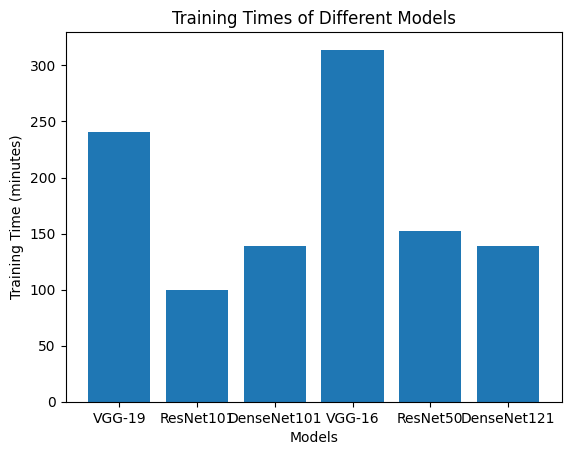

In [ ]:
import matplotlib.pyplot as plt

models = ['VGG-19', 'ResNet101', 'DenseNet101', 'VGG-16', 'ResNet50', 'DenseNet121']
training_times = [241, 100, 139, 314, 152, 139]

plt.bar(models, training_times)
plt.xlabel('Models')
plt.ylabel('Training Time (minutes)')
plt.title('Training Times of Different Models')
plt.show()


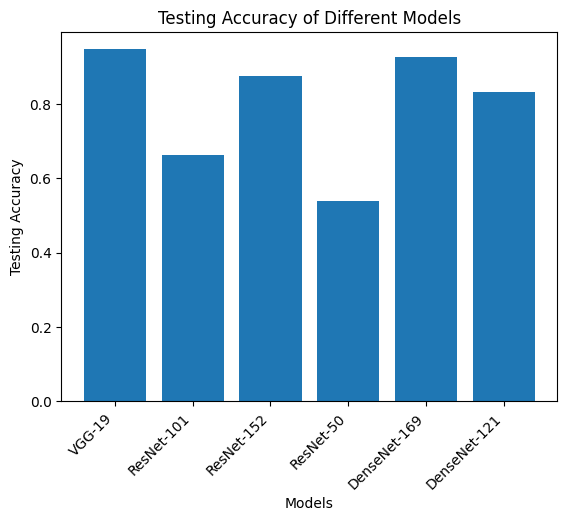

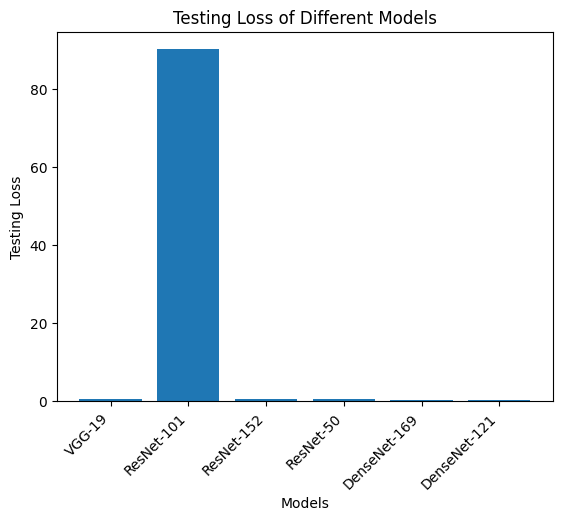

In [ ]:
import matplotlib.pyplot as plt

models = ['VGG-19', 'ResNet-101', 'ResNet-152', 'ResNet-50', 'DenseNet-169', 'DenseNet-121']
test_accuracy = [0.9453781247138977, 0.6632124185562134, 0.8739495873451233, 0.5378151535987854, 0.924369752407074, 0.831932783126831]
test_loss = [0.6909425854682922, 90.07926177978516, 0.5370689630508423, 0.6906895637512207, 0.33850857615470886, 0.4863419830799103]

plt.bar(models, test_accuracy)
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of Different Models')

# Adjust the gap between the labels on the X-axis
plt.xticks(rotation=45, ha='right')

plt.show()

plt.bar(models, test_loss)
plt.xlabel('Models')
plt.ylabel('Testing Loss')
plt.title('Testing Loss of Different Models')

# Adjust the gap between the labels on the X-axis
plt.xticks(rotation=45, ha='right')

plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
Fold: 1


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.3570 - accuracy: 0.9026 
Epoch 1: val_accuracy improved from -inf to 0.92105, saving model to vgg19_fold2.h5
24/24 [==============================] - 795s 33s/step - loss: 1.3570 - accuracy: 0.9026 - val_loss: 1.2198 - val_accuracy: 0.9211
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.9566 
Epoch 2: val_accuracy improved from 0.92105 to 0.94211, saving model to vgg19_fold2.h5
24/24 [==============================] - 780s 33s/step - loss: 0.3996 - accuracy: 0.9566 - val_loss: 0.3298 - val_accuracy: 0.9421
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9789 
Epoch 3: val_accuracy improved from 0.94211 to 0.96842, saving model to vgg19_fold2.h5
24/24 [==============================] - 783s 33s/step - loss: 0.0991 - accuracy: 0.9789 - val_loss: 0.1880 - val_accuracy: 0.9684
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 

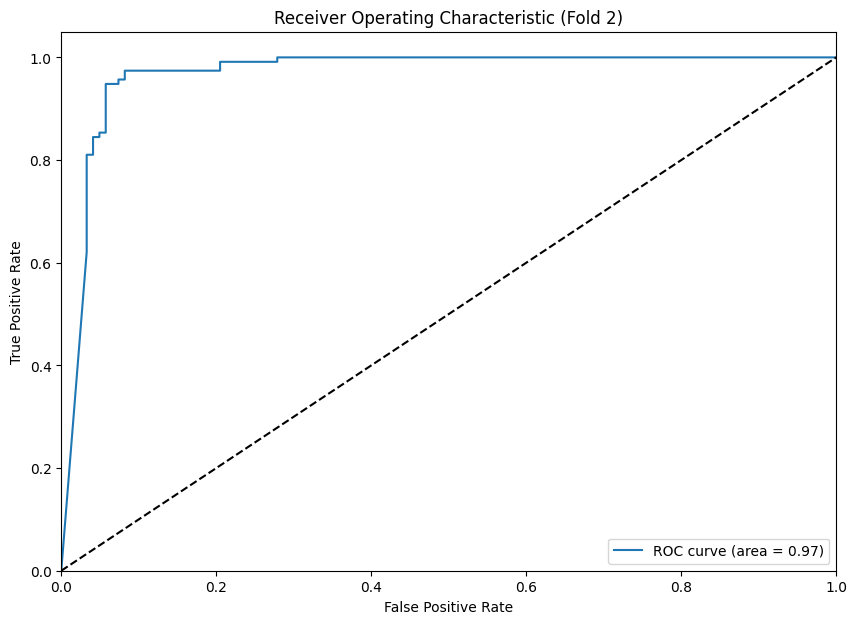

Fold: 2
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9908 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_fold3.h5
24/24 [==============================] - 777s 33s/step - loss: 0.0549 - accuracy: 0.9908 - val_loss: 6.2575e-04 - val_accuracy: 1.0000
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9961 
Epoch 2: val_accuracy did not improve from 1.00000
24/24 [==============================] - 776s 33s/step - loss: 0.0221 - accuracy: 0.9961 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 3.6728e-04 - accuracy: 1.0000 
Epoch 3: val_accuracy did not improve from 1.00000
24/24 [==============================] - 777s 33s/step - loss: 3.6728e-04 - accuracy: 1.0000 - val_loss: 2.3442e-04 - val_accuracy: 1.0000
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 7.6290e-05 - accuracy: 1.0000 
Epoch 4: val_accu

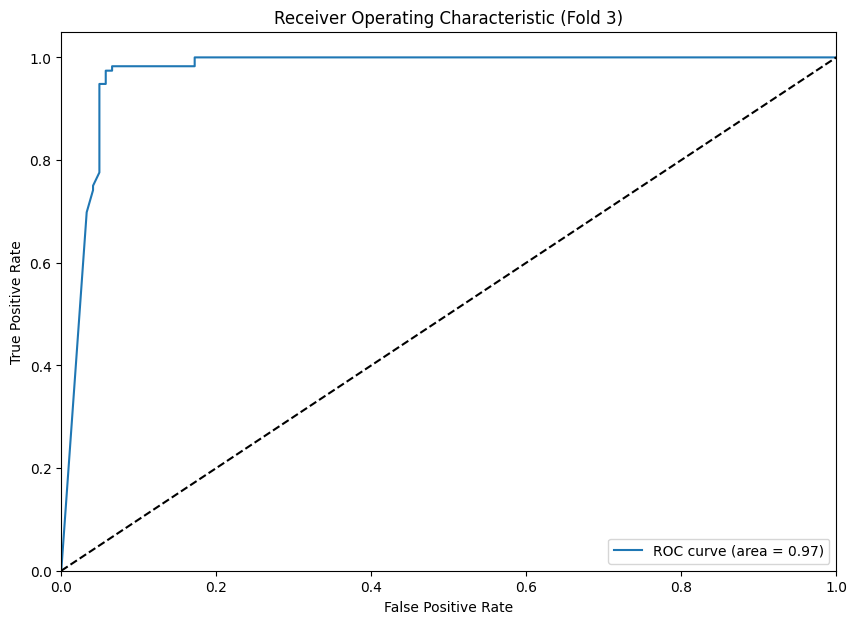

Fold: 3
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 6.9780e-05 - accuracy: 1.0000 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_fold4.h5


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-6b325c79b47d>", line 58, in <cell line: 44>
    history = model.fit(x_train_fold, y_train_fold, batch_size=32, epochs=5,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 126, in h5py.h5

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set the image size
image_size = 224

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Instantiate VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers of the pre-trained VGG19 model
for layer in vgg.layers:
    layer.trainable = False

# Create a sequential model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Set up cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Start the timer
start_time = time.time()

# Perform cross-validation
fold = 1
for train_index, val_index in kfold.split(x_train, y_train):
    print(f"Fold: {fold}")
    fold += 1

    # Split data into training and validation sets
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Set up callbacks
    checkpoint = ModelCheckpoint(f"vgg19_fold{fold}.h5", monitor="val_accuracy", verbose=1,
                                 save_best_only=True, save_weights_only=False, period=1)
    earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

    # Train the model on the current fold
    history = model.fit(x_train_fold, y_train_fold, batch_size=32, epochs=5,
                        validation_data=(x_val_fold, y_val_fold), verbose=1,
                        callbacks=[checkpoint, earlystop])

    # Evaluate the model on the current fold
    loss, accuracy = model.evaluate(x_val_fold, y_val_fold)
    print("Validation Loss:", loss)
    print("Validation Accuracy:", accuracy)

    # Generate predictions on the testing set
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Generate classification report
    target_names = ['Normal', 'Cataract']
    classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
    print(classification_rep)

    # Plot the ROC curve for the current fold
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold})')
    plt.legend(loc="lower right")
    plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')
